In [121]:
import numpy as np               # linear algebra
import pandas as pd              # data processing, dataset file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization & graphical plotting
import seaborn as sns            # to visualize random distributions
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier,export_text
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import math
import joblib
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [122]:
data_path=r'D:\HeartRate Classification\data\heart_disease.csv'

In [123]:
df = pd.read_csv(data_path)
df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,Male,39,postgraduate,0,0.0,0.0,no,0,0,195.0,106.0,70.0,26.97,80.0,77.0,No
1,Female,46,primaryschool,0,0.0,0.0,no,0,0,250.0,121.0,81.0,28.73,95.0,76.0,No
2,Male,48,uneducated,1,20.0,0.0,no,0,0,245.0,127.5,80.0,25.34,75.0,70.0,No
3,Female,61,graduate,1,30.0,0.0,no,1,0,225.0,150.0,95.0,28.58,65.0,103.0,yes
4,Female,46,graduate,1,23.0,0.0,no,0,0,285.0,130.0,84.0,23.10,85.0,85.0,No


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           4238 non-null   object 
 1   age              4238 non-null   int64  
 2   education        4133 non-null   object 
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   object 
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  Heart_stroke     4238 non-null   object 
dtypes: float64(8), int64(4), object(4)
memory usage: 529.9+ KB


# Preprocessing data

## Encode data

In [125]:
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})
df['education'] = df['education'].replace({'uneducated': 0, np.nan : 1,'primaryschool':2,'graduate':3,'postgraduate':4})
df['prevalentStroke'] = df['prevalentStroke'].replace({'no': 0, 'yes': 1})
df['Heart_stroke'] = df['Heart_stroke'].replace({'No': 0, 'yes': 1})

df.head()

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_stroke
0,0,39,4,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1,46,2,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,0,48,0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1,61,3,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1,46,3,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Impute missing data

In [126]:
# The data includes some smokers who do not know how many cigarettes they smoke in a day, so this function
# will calculate the average number of cigarettes consumed by smokers in a day
# to provide supplementary information for those who do not have it.

mean_cigsPerDay = df[df['currentSmoker'] == 1].loc[:,'cigsPerDay'].mean()
mean_cigsPerDay =math.ceil(mean_cigsPerDay)
df['cigsPerDay'] = df['cigsPerDay'].replace({np.nan : mean_cigsPerDay})

In [127]:
nan_columns = [column for column in df.columns if df[column].isna().any()]
nan_columns

['BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

In [128]:
def inpute_missing_data(df, col):
    age = df[df[col].isna()].loc[:,'age']
    for i in age:
        mean_value = math.ceil(df[df['age'] == i].loc[:,col].mean())
        df[col] = df[col].replace({np.nan : mean_value})

In [129]:
# For the missing data entries, we will calculate the average value of the missing information 
# among individuals with the same age as the person with missing data, and add it to the missing entry.
for col in nan_columns:
    inpute_missing_data(df,col)

# Select importance features

In [130]:
## Now we check the corrleation of features with the target variable (Heart Stroke)
corr_matrix = df.corr()

list_features_corr = corr_matrix['Heart_stroke'].abs().sort_values(ascending=False)
list_selected_features_index  = list_features_corr.index[:11]

# Chọn 10 feature có tương quan cao nhất
df = df[list_selected_features_index]
df.head()


,Heart_stroke,age,sysBP,prevalentHyp,diaBP,glucose,diabetes,Gender,BPMeds,totChol,BMI
0,0,39,106.0,0,70.0,77.0,0,0,0.0,195.0,26.97
1,0,46,121.0,0,81.0,76.0,0,1,0.0,250.0,28.73
2,0,48,127.5,0,80.0,70.0,0,0,0.0,245.0,25.34
3,1,61,150.0,1,95.0,103.0,0,1,0.0,225.0,28.58
4,0,46,130.0,0,84.0,85.0,0,1,0.0,285.0,23.10


# EDA

C:\Users\nguye\AppData\Local\Temp\ipykernel_12136\2404708775.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


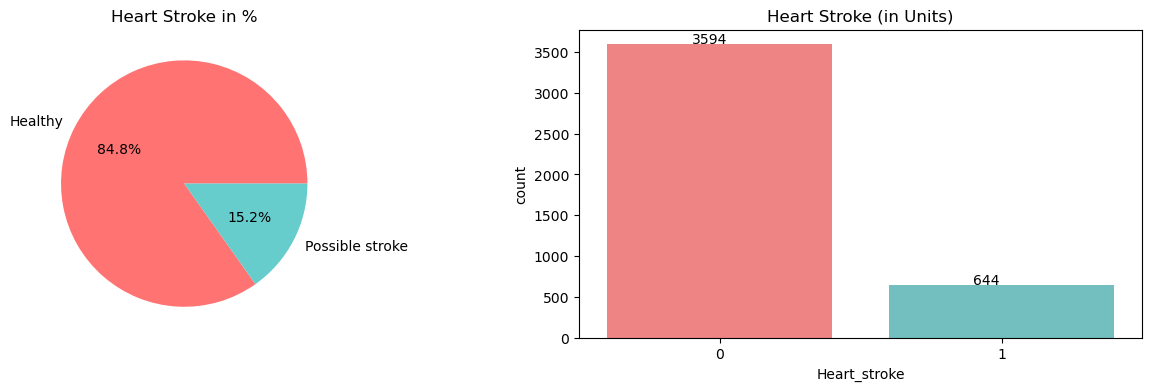

In [131]:
target = "Heart_stroke"

# Tạo danh sách màu sắc tương ứng với từng lớp
colors = ['#FF7373', '#66CCCC']


# Tính tỷ lệ phần trăm giữa các lớp
class_counts = df[target].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

plt.subplots(figsize=(16,4))

plt.subplot(1,2,1)
# Tạo biểu đồ pie chart
ax = plt.pie(class_percentages, labels=["Healthy", "Possible stroke"], autopct='%1.1f%%', colors=colors)
plt.title("Heart Stroke in %")

plt.subplot(1,2,2)
ax = sns.countplot(x="Heart_stroke", data=df, palette=colors, order=df["Heart_stroke"].value_counts().index)
plt.title("Heart Stroke (in Units)")
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+8))
# Hiển thị biểu đồ
plt.show()

--> Tập dữ liệu lệch về số ca "khỏe mạnh"

# EDA -- view data feature distribution

In [132]:
def plot_distribute(column):
    sns.displot(data=df[column], kde=True, color='#FD3333',
            line_kws={'lw': 2}, facecolor='#66CCCC', edgecolor='black')
    plt.title(f"{column} distribution")
    plt.show()

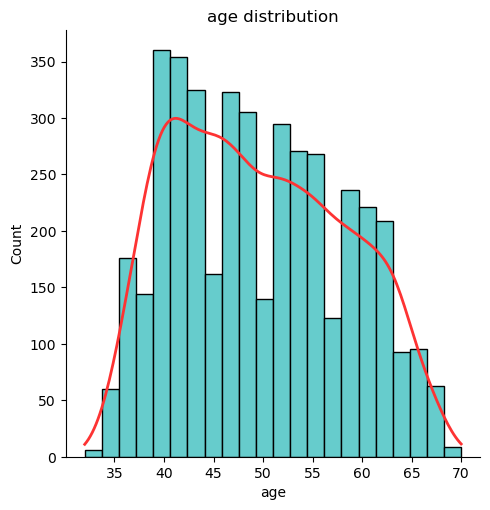

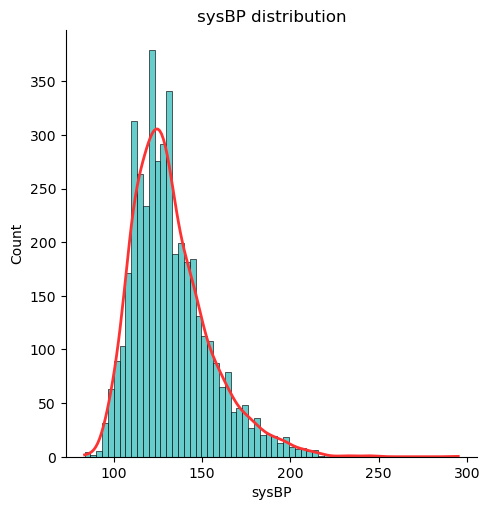

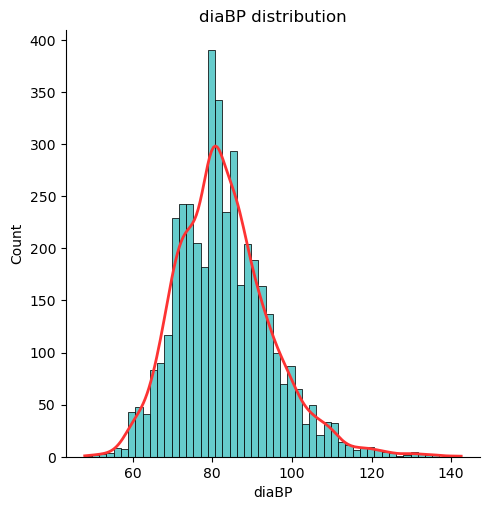

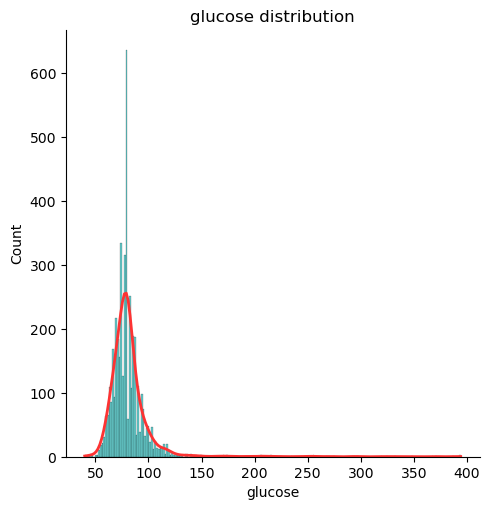

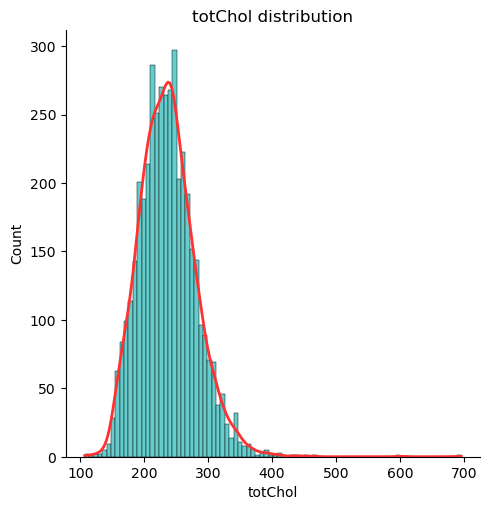

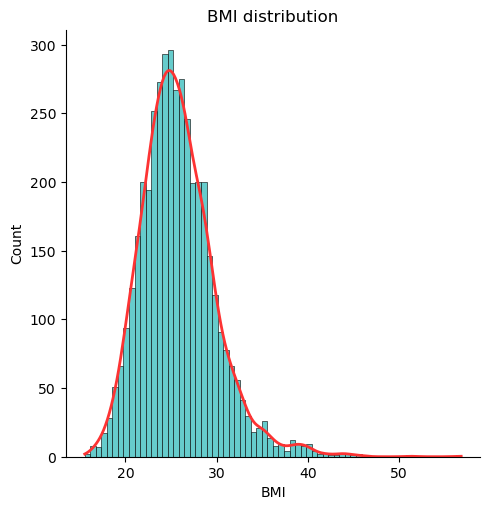

In [133]:
list_features = df.columns.to_list()
norminal_col = ["Gender", "diabetes", "currentSmoker", "BPMeds", "prevalentStroke", "prevalentHyp"]
for col in list_features[1:]:
    if col not in norminal_col:
        plot_distribute(col)

# Slip and label 

## Select features and target

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Heart_stroke  4238 non-null   int64  
 1   age           4238 non-null   int64  
 2   sysBP         4238 non-null   float64
 3   prevalentHyp  4238 non-null   int64  
 4   diaBP         4238 non-null   float64
 5   glucose       4238 non-null   float64
 6   diabetes      4238 non-null   int64  
 7   Gender        4238 non-null   int64  
 8   BPMeds        4238 non-null   float64
 9   totChol       4238 non-null   float64
 10  BMI           4238 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 364.3 KB


In [135]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [136]:
X.drop(columns=['totChol','glucose'],inplace= True)

In [137]:
X.columns

Index(['age', 'sysBP', 'prevalentHyp', 'diaBP', 'diabetes', 'Gender', 'BPMeds',
       'BMI'],
      dtype='object')

## Train test slipt 

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training models

In [139]:
def evaluate(model_name, df):
    threshold = 0.5
    y_pred_binary = np.where(y_pred.squeeze() >= threshold, 1, 0)

    f1 = f1_score(y_test, y_pred_binary)
    auc_roc = roc_auc_score(y_test, y_pred_binary)

    temp = pd.DataFrame({
        "model": [model_name],
        "f1" : [f1],
        "auc_roc" : [auc_roc]
    })

    df = pd.concat([df, temp])
    return df

In [140]:
# eval_df used to stored metrics values
eval_df = pd.DataFrame()
# 11
rf_classifier = RandomForestClassifier()
dtree_classifier = DecisionTreeClassifier(max_depth= 11)
svm_classifier = SVC()
nb_classifier = GaussianNB()
gb_classifier = GradientBoostingClassifier()
knn = KNeighborsClassifier(4, weights="distance")

model_names = [
    'RandomForest',
    "DecisionTree",
    "SVC",
    "NB",
    "Gradient Boosting",
    "KNN"
]

models = [
    rf_classifier,
    dtree_classifier, 
    svm_classifier,
    nb_classifier,
    gb_classifier,
    knn,
]

for i in range(len(models)):
    print("##################################################")
    print(model_names[i])
    model = models[i]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    eval_df = evaluate(model_names[i], eval_df)

    # Tạo ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()
    print()
    joblib.dump(model, f'{model_names[i]}.pkl')
eval_df

##################################################
RandomForest
Confusion Matrix:
[[706  18]
 [111  13]]


##################################################
DecisionTree
Confusion Matrix:
[[687  37]
 [110  14]]


##################################################
SVC
Confusion Matrix:
[[724   0]
 [124   0]]


##################################################
NB
Confusion Matrix:
[[662  62]
 [ 96  28]]


##################################################
Gradient Boosting
Confusion Matrix:
[[710  14]
 [118   6]]


##################################################
KNN
Confusion Matrix:
[[667  57]
 [110  14]]




,model,f1,auc_roc
0,RandomForest,0.167742,0.539988
0,DecisionTree,0.160000,0.530899
0,SVC,0.000000,0.500000
0,NB,0.261682,0.570086
0,Gradient Boosting,0.083333,0.514525
0,KNN,0.143590,0.517087


## Important features


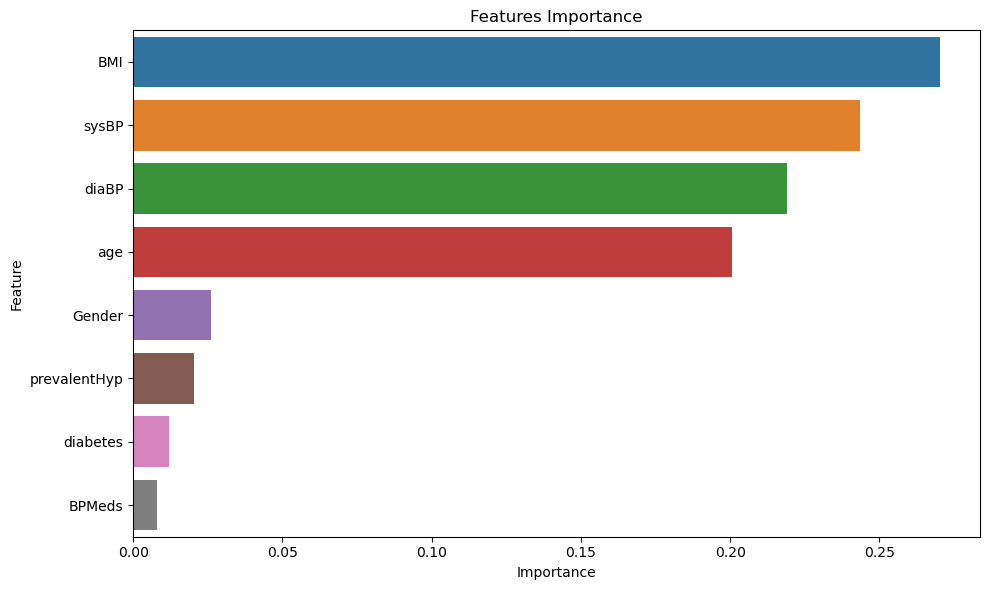

In [141]:
importances = rf_classifier.feature_importances_
feature_names = X_train.columns


feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})


feature_importances = feature_importances.sort_values('Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features Importance')
plt.tight_layout()
plt.show()

# plot tree

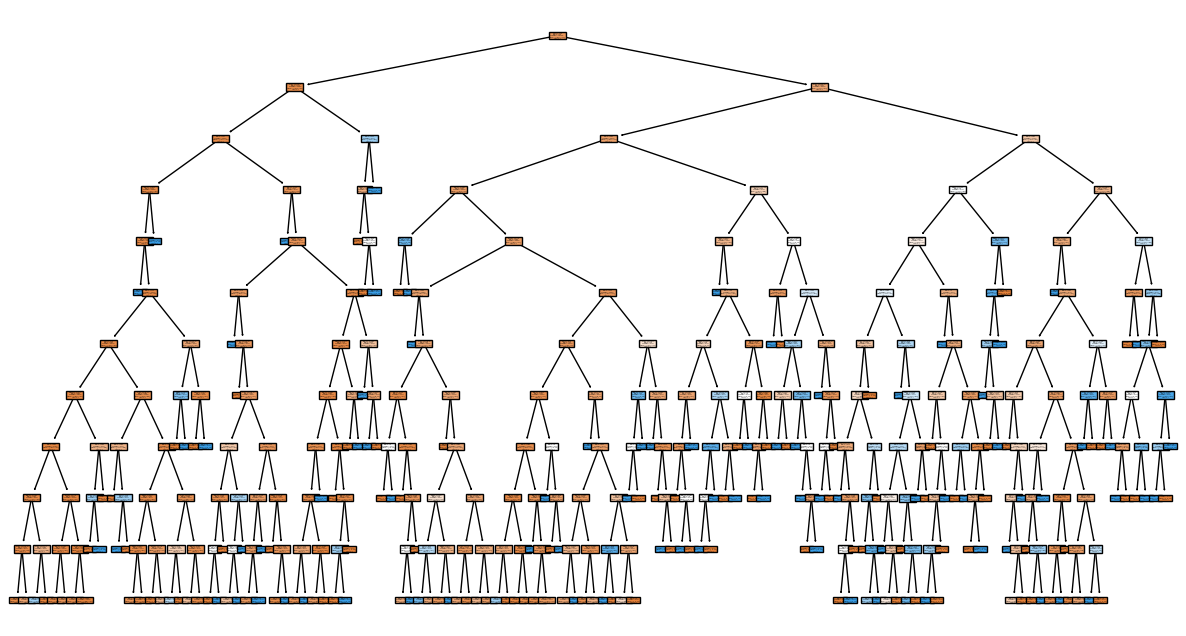

In [142]:
plt.figure(figsize=(15, 8))
plot_tree(
    dtree_classifier,
    filled=True,
    feature_names=X_train.columns,
    class_names=[str(c) for c in dtree_classifier.classes_],
    proportion=True
)
plt.show()

In [143]:
tree_text = export_text(dtree_classifier, feature_names=list(X_train.columns))
print(tree_text)

|--- age <= 48.50
|   |--- sysBP <= 192.00
|   |   |--- diaBP <= 89.75
|   |   |   |--- BMI <= 39.81
|   |   |   |   |--- sysBP <= 86.75
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sysBP >  86.75
|   |   |   |   |   |--- sysBP <= 150.25
|   |   |   |   |   |   |--- age <= 44.50
|   |   |   |   |   |   |   |--- diabetes <= 0.50
|   |   |   |   |   |   |   |   |--- BMI <= 22.18
|   |   |   |   |   |   |   |   |   |--- BMI <= 22.15
|   |   |   |   |   |   |   |   |   |   |--- sysBP <= 133.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- sysBP >  133.75
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- BMI >  22.15
|   |   |   |   |   |   |   |   |   |   |--- sysBP <= 111.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- sysBP >  111.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   | 